# Продвинутое глубокое обучение и обучение с подкреплением: ДЗ 3

Студент: Бакулев Владимир Леонидович

Группа: MADE-DS-32

Почта: vlbakulev@gmail.com

In [1]:
import os
import glob

import numpy as np

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import segmentation_models_pytorch as smp

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data).  Датасет можно скачать здесь (и во многих других местах, должно быть ~29 мегабайт).

В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля.

##### Dataset

In [3]:
DATA_PATH = os.path.join("dataset", "facades")

TRAIN_DATA_PATH = os.path.join(DATA_PATH, "train")
TEST_DATA_PATH = os.path.join(DATA_PATH, "test")

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_path):
        super(ImageDataset, self).__init__()
        
        self.images = glob.glob(os.path.join(data_path, "*.jpg"))
        self.transforms = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        foto, scheme = image[:, :256, :], image[:, 256:, :]
        return self.transforms(foto), self.transforms(scheme)

In [5]:
train_dataset = ImageDataset(data_path=TRAIN_DATA_PATH)
test_dataset = ImageDataset(data_path=TEST_DATA_PATH)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

##### Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.model = smp.Unet(
            encoder_name="resnet18",
            encoder_weights="imagenet",
            in_channels=3,
        )
        
        for param in self.model.parameters():
            param.requires_grad = True
            
        self.model.segmentation_head = nn.Sequential(
            nn.Conv2d(16, 3, 3, 1, 1),
            nn.Tanh()
        )
        
    def forward(self, img):
        return self.model(img)
        
G = Generator()
G.to(device);

In [8]:
foto, mask = next(iter(train_dataloader))
mask = mask.to(device)
print(G(mask).shape)

torch.Size([8, 3, 256, 256])


/home/bakulev/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


##### Discriminator

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def block(in_features, out_features):
            return nn.Sequential(
                nn.Conv2d(in_features, out_features, kernel_size=(4, 4), stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.LeakyReLU(0.2, inplace=True),
            )
        
        self.blocks = nn.Sequential(
            *block(6, 64),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.blocks(x)
        x = x.squeeze(-1).squeeze(-1) 
        return self.fc(x)
    
D = Discriminator()
D.to(device);

In [10]:
foto, mask = next(iter(train_dataloader))
foto_and_mask = torch.cat((foto, mask), 1).to(device)
print(D(foto_and_mask).shape)

torch.Size([8, 2])


##### Обучение

In [11]:
lr, beta1, beta2 = 0.0001, 0.5, 0.999
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

adversarial_loss = nn.MSELoss().to(device)
L1_loss = nn.MSELoss().to(device)

In [12]:
NUM_EPOCHS = 200
LAMBDA = 100
G_losses, D_losses = [], []

G.train()
D.train()
for epoch in range(NUM_EPOCHS):
    for i, (real_foto, mask) in enumerate(train_dataloader):
        real_foto = real_foto.to(device)
        mask = mask.to(device)
        
        # Обучение дискриминатора
        G.eval()
        D.train()
        
        fake_foto = G(mask)
        fake_foto_and_mask = torch.cat((fake_foto, mask), 1).to(device)
        real_foto_and_mask = torch.cat((real_foto, mask), 1).to(device)
        
        D_fake = D(fake_foto_and_mask)
        D_real = D(real_foto_and_mask)
        
        loss_D = 0.5 * (
            F.cross_entropy(D_fake, torch.zeros(D_fake.shape[0]).long().to(device)) + 
            F.cross_entropy(D_real, torch.ones(D_real.shape[0]).long().to(device))
        )
        
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        D_losses.append(loss_D.item())
            
        # Обучение генератора
        G.train()
        D.eval()
            
        fake_foto = G(mask)
        fake_foto_and_mask = torch.cat((fake_foto, mask), 1).to(device)
        D_fake = D(fake_foto_and_mask)
        
        loss_G = (
            F.cross_entropy(D_fake, torch.ones(D_real.shape[0]).long().to(device)) + 
            LAMBDA * F.l1_loss(fake_foto, real_foto)
        )
        
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        G_losses.append(loss_G.item())
    
    print(f"\t...epoch {epoch}/{NUM_EPOCHS}\tD_loss: {D_losses[-1]}\tG_loss: {G_losses[-1]}")
    
    if epoch % 10 == 0:
        
        with open('G_losses.npy', 'wb') as f_G:
            np.save(f_G, np.array(G_losses))
            
        with open('D_losses.npy', 'wb') as f_D:
            np.save(f_D, np.array(D_losses))
            
        torch.save(G.state_dict(), f"G_epoch_{epoch}.pth")
        torch.save(D.state_dict(), f"D_epoch_{epoch}.pth")

	...epoch 0/200	D_loss: 0.5217101573944092	G_loss: 38.448097229003906
	...epoch 1/200	D_loss: 0.4743706285953522	G_loss: 37.66170120239258
	...epoch 2/200	D_loss: 0.2800311744213104	G_loss: 40.85251235961914
	...epoch 3/200	D_loss: 0.24016505479812622	G_loss: 33.045249938964844
	...epoch 4/200	D_loss: 0.18039491772651672	G_loss: 29.046947479248047
	...epoch 5/200	D_loss: 0.12794947624206543	G_loss: 29.967830657958984
	...epoch 6/200	D_loss: 0.13432517647743225	G_loss: 31.23986053466797
	...epoch 7/200	D_loss: 0.08917134255170822	G_loss: 29.75271987915039
	...epoch 8/200	D_loss: 0.14530014991760254	G_loss: 25.402191162109375
	...epoch 9/200	D_loss: 0.13531802594661713	G_loss: 25.971792221069336
	...epoch 10/200	D_loss: 0.0846245139837265	G_loss: 27.572044372558594
	...epoch 11/200	D_loss: 0.545306384563446	G_loss: 25.677326202392578
	...epoch 12/200	D_loss: 0.21107541024684906	G_loss: 25.195785522460938
	...epoch 13/200	D_loss: 0.2070930302143097	G_loss: 25.905439376831055
	...epoch 14/

	...epoch 116/200	D_loss: 0.2929433584213257	G_loss: 16.153467178344727
	...epoch 117/200	D_loss: 0.23129424452781677	G_loss: 17.637676239013672
	...epoch 118/200	D_loss: 0.43547093868255615	G_loss: 14.012475967407227
	...epoch 119/200	D_loss: 0.3906289339065552	G_loss: 16.70171356201172
	...epoch 120/200	D_loss: 0.3437718152999878	G_loss: 15.787839889526367
	...epoch 121/200	D_loss: 0.272339403629303	G_loss: 17.73934555053711
	...epoch 122/200	D_loss: 0.33444058895111084	G_loss: 15.690324783325195
	...epoch 123/200	D_loss: 0.6227810978889465	G_loss: 14.732327461242676
	...epoch 124/200	D_loss: 0.27648454904556274	G_loss: 16.355777740478516
	...epoch 125/200	D_loss: 0.24545612931251526	G_loss: 14.048945426940918
	...epoch 126/200	D_loss: 0.3128588795661926	G_loss: 15.433119773864746
	...epoch 127/200	D_loss: 0.2965179681777954	G_loss: 13.415111541748047
	...epoch 128/200	D_loss: 0.31595277786254883	G_loss: 15.062010765075684
	...epoch 129/200	D_loss: 0.265804648399353	G_loss: 17.548650

##### Результат

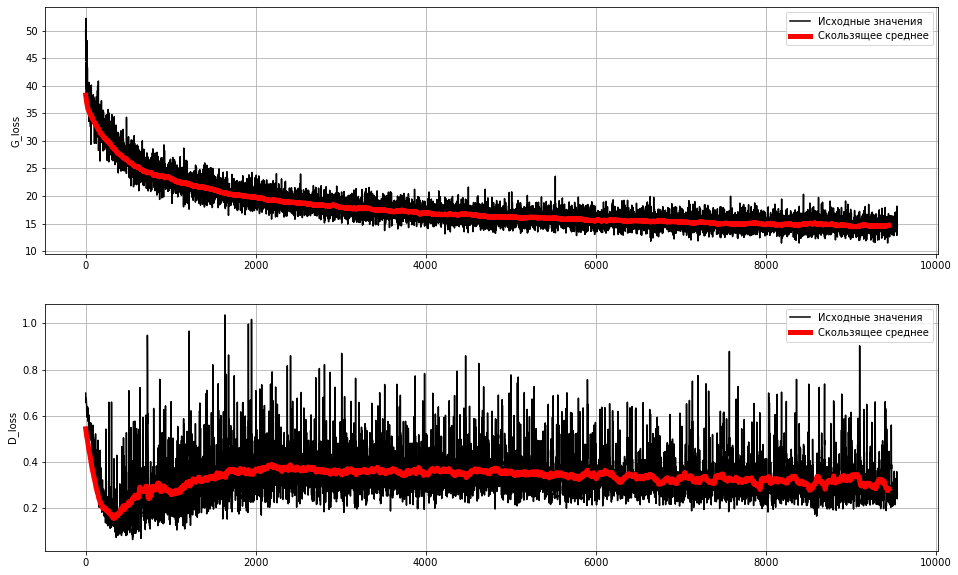

In [13]:
G_losses = np.load('G_losses.npy')
D_losses = np.load('D_losses.npy')

def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

axes[0].plot(G_losses, "k", label="Исходные значения")
axes[0].plot(moving_average(G_losses), "r", linewidth=5, label="Скользящее среднее")
axes[0].set_ylabel("G_loss")

axes[1].plot(D_losses, "k", label="Исходные значения")
axes[1].plot(moving_average(D_losses), "r", linewidth=5, label="Скользящее среднее")
axes[1].set_ylabel("D_loss")

for i in range(2):
    axes[i].legend()
    axes[i].grid()

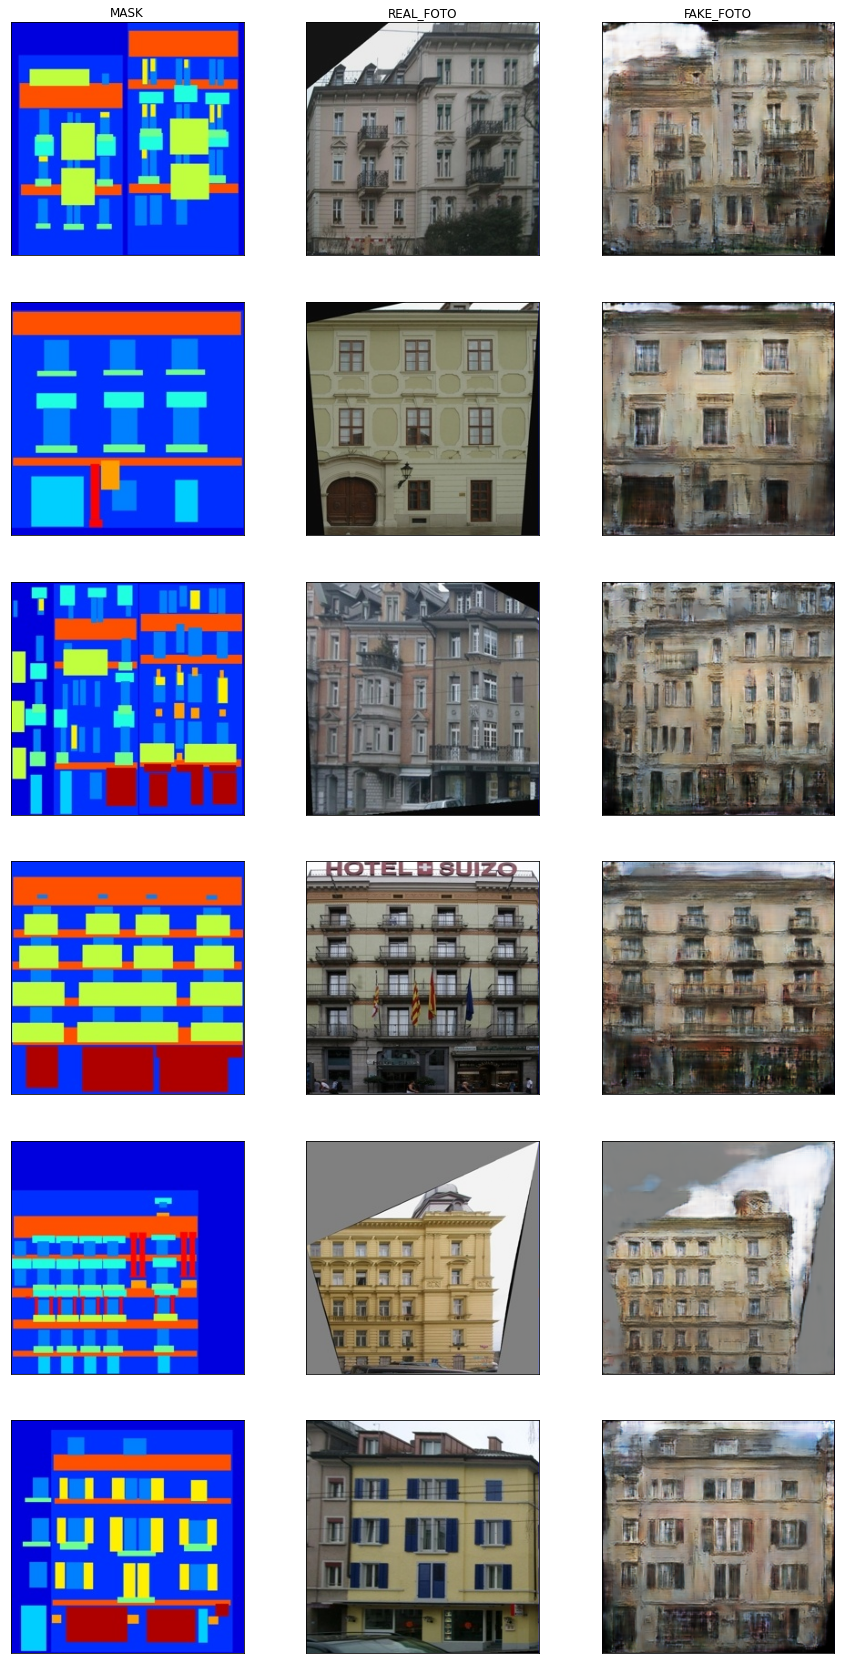

In [15]:
epoch_for_load = 190 # NUM_EPOCHS

G_test = Generator()
G_test.load_state_dict(torch.load(f"G_epoch_{epoch_for_load}.pth"))
G_test.eval()

COUNT_TEST = 6
fig, axes = plt.subplots(nrows=COUNT_TEST, ncols=3, figsize=(15, COUNT_TEST * 5))

for j, (real_foto, mask) in enumerate(test_dataloader):
    
    if j == COUNT_TEST:
        break
    
    for k in range(3):
        axes[j, k].get_xaxis().set_visible(False)
        axes[j, k].get_yaxis().set_visible(False)
    
    axes[0, 0].set_title("MASK")
    axes[0, 1].set_title("REAL_FOTO")
    axes[0, 2].set_title("FAKE_FOTO")
    
    axes[j, 0].imshow((mask[0].numpy().transpose(1, 2, 0) + 1) / 2)
    axes[j, 1].imshow((real_foto[0].numpy().transpose(1, 2, 0) + 1) / 2)
    
    fake_foto = G_test(mask)
    axes[j, 2].imshow((fake_foto[0].detach().numpy().transpose(1, 2, 0) + 1) / 2)

### Часть вторая: добавим циклы

Вторая часть -- реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом.